# Load data

In [11]:
import pandas as pd

df_dataset = pd.read_csv("preprocessed_dataset.csv",index_col=0).drop(columns=["1d_pct_price_var","10d_pct_price_var"])

# Train - test separation and target variable discretization

In [12]:
import plotly.express as px

fig = px.histogram(df_dataset, x="5d_pct_price_var", nbins=50)
fig.update_layout(
    title="Distribution of 5-Days % Price Variation",
    xaxis_title="5d_pct_price_var",
    yaxis_title="Count",
    bargap=0.1
)
fig.show()


In [13]:
def var_class(x, alpha=0.01):
    if x < - alpha:
        return 0
    elif x > alpha:
        return 1
    else:
        return 2
df_dataset["target"] = df_dataset["5d_pct_price_var"].apply(var_class)

df_dataset.target.value_counts()

target
1    1480
0    1267
2     551
Name: count, dtype: int64

In [14]:
df_train = df_dataset.iloc[:-900]
df_test = df_dataset.iloc[-900:]

x_train = df_train.drop(columns=["target","5d_pct_price_var","observation_date"])
y_train = df_train["target"]
x_test = df_test.drop(columns=["target","5d_pct_price_var","observation_date"])
y_test = df_test["target"]

# Model Hyperparameters Selection

In [ ]:
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn.metrics import make_scorer, accuracy_score

sign_accuracy = make_scorer(accuracy_score)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "num_leaves": trial.suggest_int("num_leaves", 10, 50, step=5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
        "objective": "multiclass",
        "num_class": 3,
        "random_state": 0,
        "device": "gpu",  
        "verbose": -1
    }

    model = LGBMClassifier(**params)

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=sign_accuracy, n_jobs=-1)

    return np.mean(scores)


# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\nLGBM Optuna Results")
print("Best Sign Accuracy score (CV):", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-07-05 16:12:03,294] A new study created in memory with name: no-name-ba0c11e7-e9b4-4b2e-8a30-03c8c63da708


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-07-05 16:12:34,610] Trial 0 finished with value: 0.5254458820255983 and parameters: {'n_estimators': 100, 'max_depth': 9, 'num_leaves': 10, 'learning_rate': 0.032594908506453905, 'feature_fraction': 0.5666227481266668, 'bagging_fraction': 0.9872801221233436, 'bagging_freq': 1, 'min_child_samples': 88, 'lambda_l2': 0.5257697724883437}. Best is trial 0 with value: 0.5254458820255983.
[I 2025-07-05 16:18:44,620] Trial 1 finished with value: 0.5196083750695604 and parameters: {'n_estimators': 300, 'max_depth': 10, 'num_leaves': 50, 'learning_rate': 0.05189485633443546, 'feature_fraction': 0.6027337600611191, 'bagging_fraction': 0.7379237745129088, 'bagging_freq': 5, 'min_child_samples': 32, 'lambda_l2': 9.721125191636489}. Best is trial 0 with value: 0.5254458820255983.
[I 2025-07-05 16:51:24,126] Trial 2 finished with value: 0.5341986644407346 and parameters: {'n_estimators': 200, 'max_depth': 13, 'num_leaves': 30, 'learning_rate': 0.05647365114428465, 'feature_fraction': 0.577685

In [ ]:
from lightgbm import LGBMClassifier

params =  {'n_estimators': 250, 
           'max_depth': 6, 
           'num_leaves': 30, 
           'learning_rate': 0.061580309607505136, 
           'feature_fraction': 0.5868919497391815, 
           'bagging_fraction': 0.927960588759364, 
           'bagging_freq': 3, 
           'min_child_samples': 38, 
           'lambda_l2': 9.358270219900731,
           'device':'gpu',
           'verbose': -1,
           'random_state': 0
           }
# lgbm_reg = LGBMClassifier(**study.best_params, device="gpu", verbose=-1, random_state=0)
lgbm_class = LGBMClassifier(**params)
lgbm_class.fit(x_train,y_train)

LGBMClassifier(bagging_fraction=0.927960588759364, bagging_freq=3, device='gpu',
               feature_fraction=0.5868919497391815, lambda_l2=9.358270219900731,
               learning_rate=0.061580309607505136, max_depth=6,
               min_child_samples=38, n_estimators=250, num_leaves=30,
               random_state=0, verbose=-1)

In [ ]:
import numpy as np

def sign_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

train_preds = lgbm_class.predict(x_train)
test_preds = lgbm_class.predict(x_test)


train_sign_accuracy = sign_accuracy(y_train,train_preds)
test_sign_accuracy = sign_accuracy(y_test,test_preds)

print("Train dataset performance: ",train_sign_accuracy)
print("Test dataset performance: ",test_sign_accuracy)

Train dataset performance:  0.9987489574645538
Test dataset performance:  0.4211111111111111


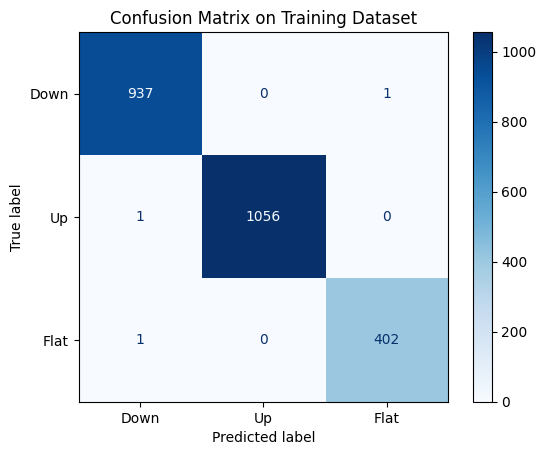

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Down","Up","Flat"],
        cmap=plt.cm.Blues
    )

    t = confusion_matrix(y_true, y_pred).ravel()

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset")

displayConfusionMatrix(y_train, train_preds, "Training")

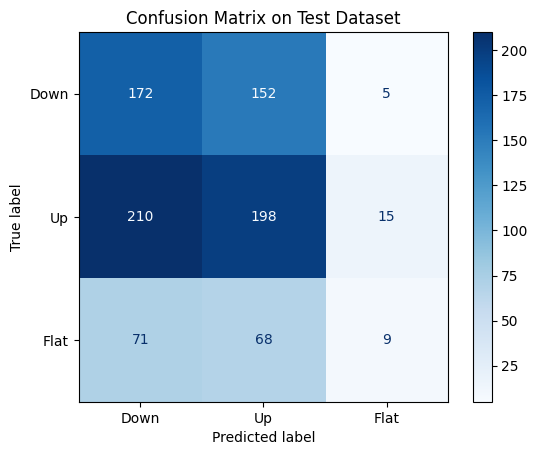

In [ ]:
displayConfusionMatrix(y_test, test_preds, "Test")